# Traditional Finite Size DMRG for Transverse-field Ising Model

Author: Haimeng Zhao

Email: haimengzhao@icloud.com

This note book utilizes the traditional finite size density matrix renormalization group (DMRG) to compute the ground state energy and entanglement entropy of transverse-field ising model.

Specifically, the Hamiltonian that we are interested in is
$$
H = -J\sum_{i=0}^{N-1} (g\sigma^x_i + \sigma^z_i\sigma^z_{i+1}),
$$
where we take $N=40, J=1, g\in \{0.6, 1.0, 1.6\}$.

Most of the following code refers to [this repo](https://github.com/simple-dmrg/simple-dmrg/blob/master/simple_dmrg_02_finite_system.py).

# Setting up utils
Firstly, we define some data structures to store the blocks we would use in DMRG.

In [1]:
# numpy and scipy imports
import numpy as np
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh  # Lanczos routine from ARPACK

# We will use python's "namedtuple" to represent the Block and EnlargedBlock
# objects
from collections import namedtuple

Block = namedtuple("Block", ["length", "basis_size", "operator_dict"])
EnlargedBlock = namedtuple("EnlargedBlock", ["length", "basis_size", "operator_dict"])

def is_valid_block(block):
    for op in block.operator_dict.values():
        if op.shape[0] != block.basis_size or op.shape[1] != block.basis_size:
            return False
    return True

# This function should test the same exact things, so there is no need to
# repeat its definition.
is_valid_enlarged_block = is_valid_block

# Setting up Ising model
Secondly, we define the Ising model. In particular, the one-size and two-size part of the Hamiltonian.

In [2]:
model_d = 2  # single-site basis size

Sz1 = np.array([[1, 0], [0, -1]], dtype='d')  # single-site sigma^z
Sx1 = np.array([[0, 1], [1, 0]], dtype='d')  # single-site sigma^x

def gen_H1(J, g):
    return -J * g * Sx1  # single-site portion of H

def H2(Sz1, Sx1, Sz2, Sx2, J):  # two-site part of H
    """Given the operators S^z and S^x on two sites in different Hilbert spaces
    (e.g. two blocks), returns a Kronecker product representing the
    corresponding two-site term in the Hamiltonian that joins the two sites.
    """
    return -J * kron(Sz1, Sz2)

# conn refers to the connection operator, that is, the operator on the edge of
# the block, on the interior of the chain.  We need to be able to represent S^z
# and S^x on that site in the current basis in order to grow the chain.
def gen_initial_block(J, g):
    return Block(length=1, basis_size=model_d, operator_dict={
        "H": gen_H1(J, g),
        "conn_Sz": Sz1,
        "conn_Sx": Sx1,
    })

# Some subroutines
To implement finite size DMRG, we need some subroutine functions to grow the block size.

## Enlarging a block

In [3]:
def enlarge_block(block, H1, J):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict

    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        "H": kron(o["H"], identity(model_d)) + kron(identity(mblock), H1) + H2(o["conn_Sz"], o["conn_Sx"], Sz1, Sx1, J),
        "conn_Sz": kron(identity(mblock), Sz1),
        "conn_Sx": kron(identity(mblock), Sx1),
    }

    return EnlargedBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)

## Basis transformation
After each DMRG step, we need to transform every operator to the new basis.

In [4]:
def rotate_and_truncate(operator, transformation_matrix):
    """Transforms the operator to the new (possibly truncated) basis given by
    `transformation_matrix`.
    """
    return transformation_matrix.conjugate().transpose().dot(operator.dot(transformation_matrix))

## A DMRG step
Now we implement a single step of DMRG: grow, trace, truncate and transform.

In [62]:
def single_dmrg_step(sys, env, m, H1, J, verbose=True):
    """Performs a single DMRG step using `sys` as the system and `env` as the
    environment, keeping a maximum of `m` states in the new basis.
    """
    assert is_valid_block(sys)
    assert is_valid_block(env)

    # Enlarge each block by a single site.
    sys_enl = enlarge_block(sys, H1, J)
    if sys is env:  # no need to recalculate a second time
        env_enl = sys_enl
    else:
        env_enl = enlarge_block(env, H1, J)

    assert is_valid_enlarged_block(sys_enl)
    assert is_valid_enlarged_block(env_enl)

    # Construct the full superblock Hamiltonian.
    m_sys_enl = sys_enl.basis_size
    m_env_enl = env_enl.basis_size
    sys_enl_op = sys_enl.operator_dict
    env_enl_op = env_enl.operator_dict
    superblock_hamiltonian = kron(sys_enl_op["H"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["H"]) + \
                             H2(sys_enl_op["conn_Sz"], sys_enl_op["conn_Sx"], env_enl_op["conn_Sz"], env_enl_op["conn_Sx"], J)

    # Call ARPACK to find the superblock ground state.  ("SA" means find the
    # "smallest in amplitude" eigenvalue.)
    (energy,), psi0 = eigsh(superblock_hamiltonian, k=1, which="SA")

    # Construct the reduced density matrix of the system by tracing out the
    # environment
    #
    # We want to make the (sys, env) indices correspond to (row, column) of a
    # matrix, respectively.  Since the environment (column) index updates most
    # quickly in our Kronecker product structure, psi0 is thus row-major ("C
    # style").
    psi0 = psi0.reshape([sys_enl.basis_size, -1], order="C")
    rho = np.dot(psi0, psi0.conjugate().transpose())

    # Diagonalize the reduced density matrix and sort the eigenvectors by
    # eigenvalue.
    evals, evecs = np.linalg.eigh(rho)
    possible_eigenstates = []
    for eval, evec in zip(evals, evecs.transpose()):
        possible_eigenstates.append((eval, evec))
    possible_eigenstates.sort(reverse=True, key=lambda x: x[0])  # largest eigenvalue first

    # compute entanglement entropy
    entropy = -np.sum(evals[evals>1e-15] * np.log(evals[evals>1e-15]))
    # print(evals)

    # Build the transformation matrix from the `m` overall most significant
    # eigenvectors.
    my_m = min(len(possible_eigenstates), m)
    transformation_matrix = np.zeros((sys_enl.basis_size, my_m), dtype='d', order='F')
    for i, (eval, evec) in enumerate(possible_eigenstates[:my_m]):
        transformation_matrix[:, i] = evec

    truncation_error = 1 - sum([x[0] for x in possible_eigenstates[:my_m]])
    if verbose:
        print("truncation error:", truncation_error) 

    # Rotate and truncate each operator.
    new_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_operator_dict[name] = rotate_and_truncate(op, transformation_matrix)

    newblock = Block(length=sys_enl.length,
                     basis_size=my_m,
                     operator_dict=new_operator_dict)

    return newblock, energy, entropy

## Visualize
To better understand the progress of DMRG, we can visualize it.

In [63]:
def graphic(sys_block, env_block, sys_label="l"):
    """Returns a graphical representation of the DMRG step we are about to
    perform, using '=' to represent the system sites, '-' to represent the
    environment sites, and '**' to represent the two intermediate sites.
    """
    assert sys_label in ("l", "r")
    graphic = ("=" * sys_block.length) + "**" + ("-" * env_block.length)
    if sys_label == "r":
        # The system should be on the right and the environment should be on
        # the left, so reverse the graphic.
        graphic = graphic[::-1]
    return graphic

# Finite size DMRG
Now we can assemble all the above subroutines and obtain the finite size DMRG.

In [64]:
def finite_system_algorithm(N, J, g, m_warmup, m_sweep_list, verbose=True):
    assert N % 2 == 0  # require that L is an even number

    # To keep things simple, this dictionary is not actually saved to disk, but
    # we use it to represent persistent storage.
    block_disk = {}  # "disk" storage for Block objects

    # Use the infinite system algorithm to build up to desired size.  Each time
    # we construct a block, we save it for future reference as both a left
    # ("l") and right ("r") block, as the infinite system algorithm assumes the
    # environment is a mirror image of the system.
    H1 = gen_H1(J, g)
    block = gen_initial_block(J, g)
    block_disk["l", block.length] = block
    block_disk["r", block.length] = block
    while 2 * block.length < N:
        # Perform a single DMRG step and save the new Block to "disk"
        block, energy, entropy = single_dmrg_step(block, block, m_warmup, H1, J, verbose)
        if verbose:
            print(graphic(block, block))
            print("E/L =", energy / (block.length * 2))
        block_disk["l", block.length] = block
        block_disk["r", block.length] = block

    # Now that the system is built up to its full size, we perform sweeps using
    # the finite system algorithm.  At first the left block will act as the
    # system, growing at the expense of the right block (the environment), but
    # once we come to the end of the chain these roles will be reversed.
    sys_label, env_label = "l", "r"
    sys_block = block; del block  # rename the variable  

    # record entropy as function of L 
    entropy_list = np.zeros(N) 
    for m in m_sweep_list:
        while True:
            # Load the appropriate environment block from "disk"
            env_block = block_disk[env_label, N - sys_block.length - 2]

                        # record entropy
            entropy_list[sys_block.length] = entropy
            if env_block.length == 1:
                # We've come to the end of the chain, so we reverse course.
                sys_block, env_block = env_block, sys_block
                sys_label, env_label = env_label, sys_label

            # Perform a single DMRG step.
            sys_block, energy, entropy = single_dmrg_step(sys_block, env_block, m, H1, J, verbose)

            if verbose:
                print(graphic(sys_block, env_block, sys_label))
                print(f"E/L = {energy / N}, E = {energy}, S = {entropy}")

            # Save the block from this step to disk.
            block_disk[sys_label, sys_block.length] = sys_block

            # Check whether we just completed a full sweep.
            if sys_label == "l" and 2 * sys_block.length == N:
                break  # escape from the "while True" loop

    return energy, entropy_list

# Demo
Let's give it a try ($N=40, J=1, g=1.6, m=20$)!

In [65]:
np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)
gs_energy, entropy_list = finite_system_algorithm(N=40, J=1, g=1, m_warmup=20, m_sweep_list=[20, 20, 20])

truncation error: 0.0
==**--
E/L = -1.1896926207859086
truncation error: -2.220446049250313e-16
===**---
E/L = -1.2160383017597935
truncation error: 3.3306690738754696e-16
====**----
E/L = -1.2297439309324292
truncation error: -1.1102230246251565e-15
=====**-----
E/L = -1.2381489999654742
truncation error: -4.440892098500626e-16
======**------
E/L = -1.2438309258257203
truncation error: -2.220446049250313e-16
=======**-------
E/L = -1.247928861052241
truncation error: 7.771561172376096e-16
========**--------
E/L = -1.251024243780195
truncation error: 1.6653345369377348e-15
=========**---------
E/L = -1.2534449291569172
truncation error: 1.3322676295501878e-15
==========**----------
E/L = -1.2553898555801495
truncation error: 2.3314683517128287e-15
===========**-----------
E/L = -1.2569867430814587
truncation error: 4.3298697960381105e-15
============**------------
E/L = -1.2583213471332562
truncation error: 1.2101430968414206e-14
=============**-------------
E/L = -1.259453386640669
tr

# Task
Our task is to find the ground state energy and plot the entanglement entropy $S(L)$ as a function of $L$ for the following parameters:

1. $N = 40, J = 1, m = 40, g = 0.6, 1.0, 1.6$

For g = 0.6, ground state energy = -42.879001998825586, entropy:
[0.           0.           0.6361770517 0.6764738188 0.6910707293 0.6964098365 0.6983641801 0.6990784365 0.6993389611 0.6994338149 0.6994682979 0.6994808186 0.6994853595 0.6994870028 0.6994876007 0.6994878162 0.6994878947 0.6994879205 0.6994879328 0.6994879355 0.6994879364 0.6994879312 0.6994879276
 0.6994879164 0.6994878946 0.6994878135 0.6994876008 0.6994870047 0.6994853594 0.6994808183 0.6994682987 0.6994338163 0.6993389611 0.6990784341 0.6983641805 0.6964098367 0.6910707292 0.6764738188 0.           0.          ]
For g = 1.0, ground state energy = -50.56943379479497, entropy:
[0.           0.           0.3367046497 0.3750872584 0.4011932272 0.4207065691 0.4360859337 0.4486081882 0.4590179576 0.4677855468 0.4752256361 0.4815579913 0.4869410819 0.4914918807 0.4952981037 0.498426071  0.5009259018 0.5028350141 0.5041804989 0.5049807111 0.5052462869 0.5049807111 0.5041804989
 0.5028350141 0.5009259018 0.498426071  0.495298

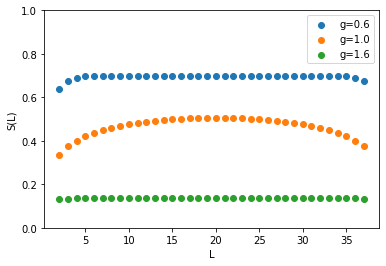

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.ylim(bottom=0)
plt.ylabel('S(L)')
plt.xlabel('L')

N = 40; J = 1; m = 40
for g in [0.6, 1.0, 1.6]:
    gs_energy, entropy_list = finite_system_algorithm(N=N, J=J, g=g, m_warmup=m, m_sweep_list=[m, m], verbose=False)
    plt.scatter(np.arange(N)[2:-2], entropy_list[2:-2])
    print(f'For g = {g}, ground state energy = {gs_energy}, entropy:\n{entropy_list}')

plt.legend(['g=0.6', 'g=1.0', 'g=1.6'])
plt.show()

Note that for $g=0.6, 1.6$, the entanglement entropy is constant due to area law (in one dim, $Area(\partial A)$ is constant).

But for critical point $g = 1.0$, long range entanglement emerges, causing the entanglement entropy to follow a log form.

2.  $N = 40, J = 1, m = 20, 40, 60, g = 1.0$

For g = 1.0, ground state energy = -50.56943379475937, entropy:
[0.           0.           0.3367046497 0.3750872583 0.401193227  0.4207065688 0.4360859334 0.4486081878 0.459017957  0.4677855461 0.4752256353 0.4815579903 0.4869410808 0.4914918794 0.4952981023 0.4984260695 0.5009259001 0.5028350123 0.504180497  0.5049807092 0.505246285  0.5049807092 0.504180497
 0.5028350123 0.5009259001 0.4984260695 0.4952981023 0.4914918794 0.4869410808 0.4815579903 0.4752256353 0.4677855461 0.459017957  0.4486081878 0.4360859334 0.4207065688 0.401193227  0.3750872583 0.           0.          ]
For g = 1.0, ground state energy = -50.56943379479505, entropy:
[0.           0.           0.3367046497 0.3750872584 0.4011932272 0.4207065691 0.4360859337 0.4486081882 0.4590179576 0.4677855468 0.4752256361 0.4815579913 0.4869410819 0.4914918807 0.4952981037 0.498426071  0.5009259018 0.5028350141 0.5041804989 0.5049807111 0.5052462869 0.5049807111 0.5041804989
 0.5028350141 0.5009259018 0.498426071  0.49529810

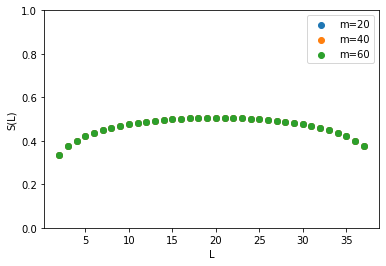

In [69]:
plt.ylim(bottom=0)
plt.ylabel('S(L)')
plt.xlabel('L')

N = 40; J = 1; g = 1.0
for m in [20, 40, 60]:
    gs_energy, entropy_list = finite_system_algorithm(N=N, J=J, g=g, m_warmup=m, m_sweep_list=[m, m], verbose=False)
    plt.scatter(np.arange(N)[2:-2], entropy_list[2:-2])
    print(f'For g = {g}, ground state energy = {gs_energy}, entropy:\n{entropy_list}')

plt.legend(['m=20', 'm=40', 'm=60'])
plt.show()

Note that the resulting ground state energy only differs in $10^{-11}$, but the speed difference is tremendous!

# Verify the log entropy at critical point
Here we plot a figure of $\ln L - S(L)$.

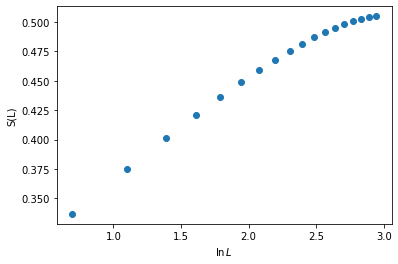

In [85]:
plt.xlabel('$\ln L$')
plt.ylabel('S(L)')
plt.scatter(np.log(np.arange(2, 20)), entropy_list[2:20])
plt.show()

The above curve looks quite linear, indicating that the entanglement entropy at critical point indeed satisifies a log form. 